In [93]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

train = pd.read_csv('training_dataset.csv')
test = pd.read_csv('validation_set.csv')

train = train.drop(columns=['customer_number'])
test = test.drop(columns=['customer_number'])

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          22916 non-null  int64  
 1   pekerjaan                     22916 non-null  object 
 2   status_perkawinan             22916 non-null  object 
 3   pendidikan                    22916 non-null  object 
 4   gagal_bayar_sebelumnya        22916 non-null  object 
 5   pinjaman_rumah                22916 non-null  object 
 6   pinjaman_pribadi              22916 non-null  object 
 7   jenis_kontak                  22916 non-null  object 
 8   bulan_kontak_terakhir         22916 non-null  object 
 9   hari_kontak_terakhir          22916 non-null  object 
 10  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 11  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 12  jumlah_kontak_sebelumnya      22916 non-null  int64  
 13  h

In [95]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
usia,22916.0,40.016233,10.438059,17.000,32.000,38.000,47.000,98.000
jumlah_kontak_kampanye_ini,22916.0,2.561878,2.794178,1.000,1.000,2.000,3.000,42.000
hari_sejak_kontak_sebelumnya,22916.0,962.210377,187.566774,0.000,999.000,999.000,999.000,999.000
jumlah_kontak_sebelumnya,22916.0,0.170143,0.490611,0.000,0.000,0.000,0.000,7.000
tingkat_variasi_pekerjaan,22916.0,0.077915,1.576176,-3.400,-1.800,1.100,1.400,1.400
indeks_harga_konsumen,22916.0,93.576541,0.580586,92.201,93.075,93.876,93.994,94.767
indeks_kepercayaan_konsumen,22916.0,-40.485717,4.641091,-50.800,-42.700,-41.800,-36.400,-26.900
suku_bunga_euribor_3bln,22916.0,3.617890,1.737591,0.634,1.344,4.857,4.961,5.045
jumlah_pekerja,22916.0,5166.773124,72.479698,4963.600,5099.100,5191.000,5228.100,5228.100
berlangganan_deposito,22916.0,0.114069,0.317902,0.000,0.000,0.000,0.000,1.000


In [96]:
train['berlangganan_deposito'] = train['berlangganan_deposito'].astype('object')

train_obj = train.select_dtypes(include=['object'])
train_obj_columns = train_obj.columns

train['berlangganan_deposito'] = train['berlangganan_deposito'].astype('bool')

train_num = train.select_dtypes(exclude=['object'])
train_num_columns = train_num.columns

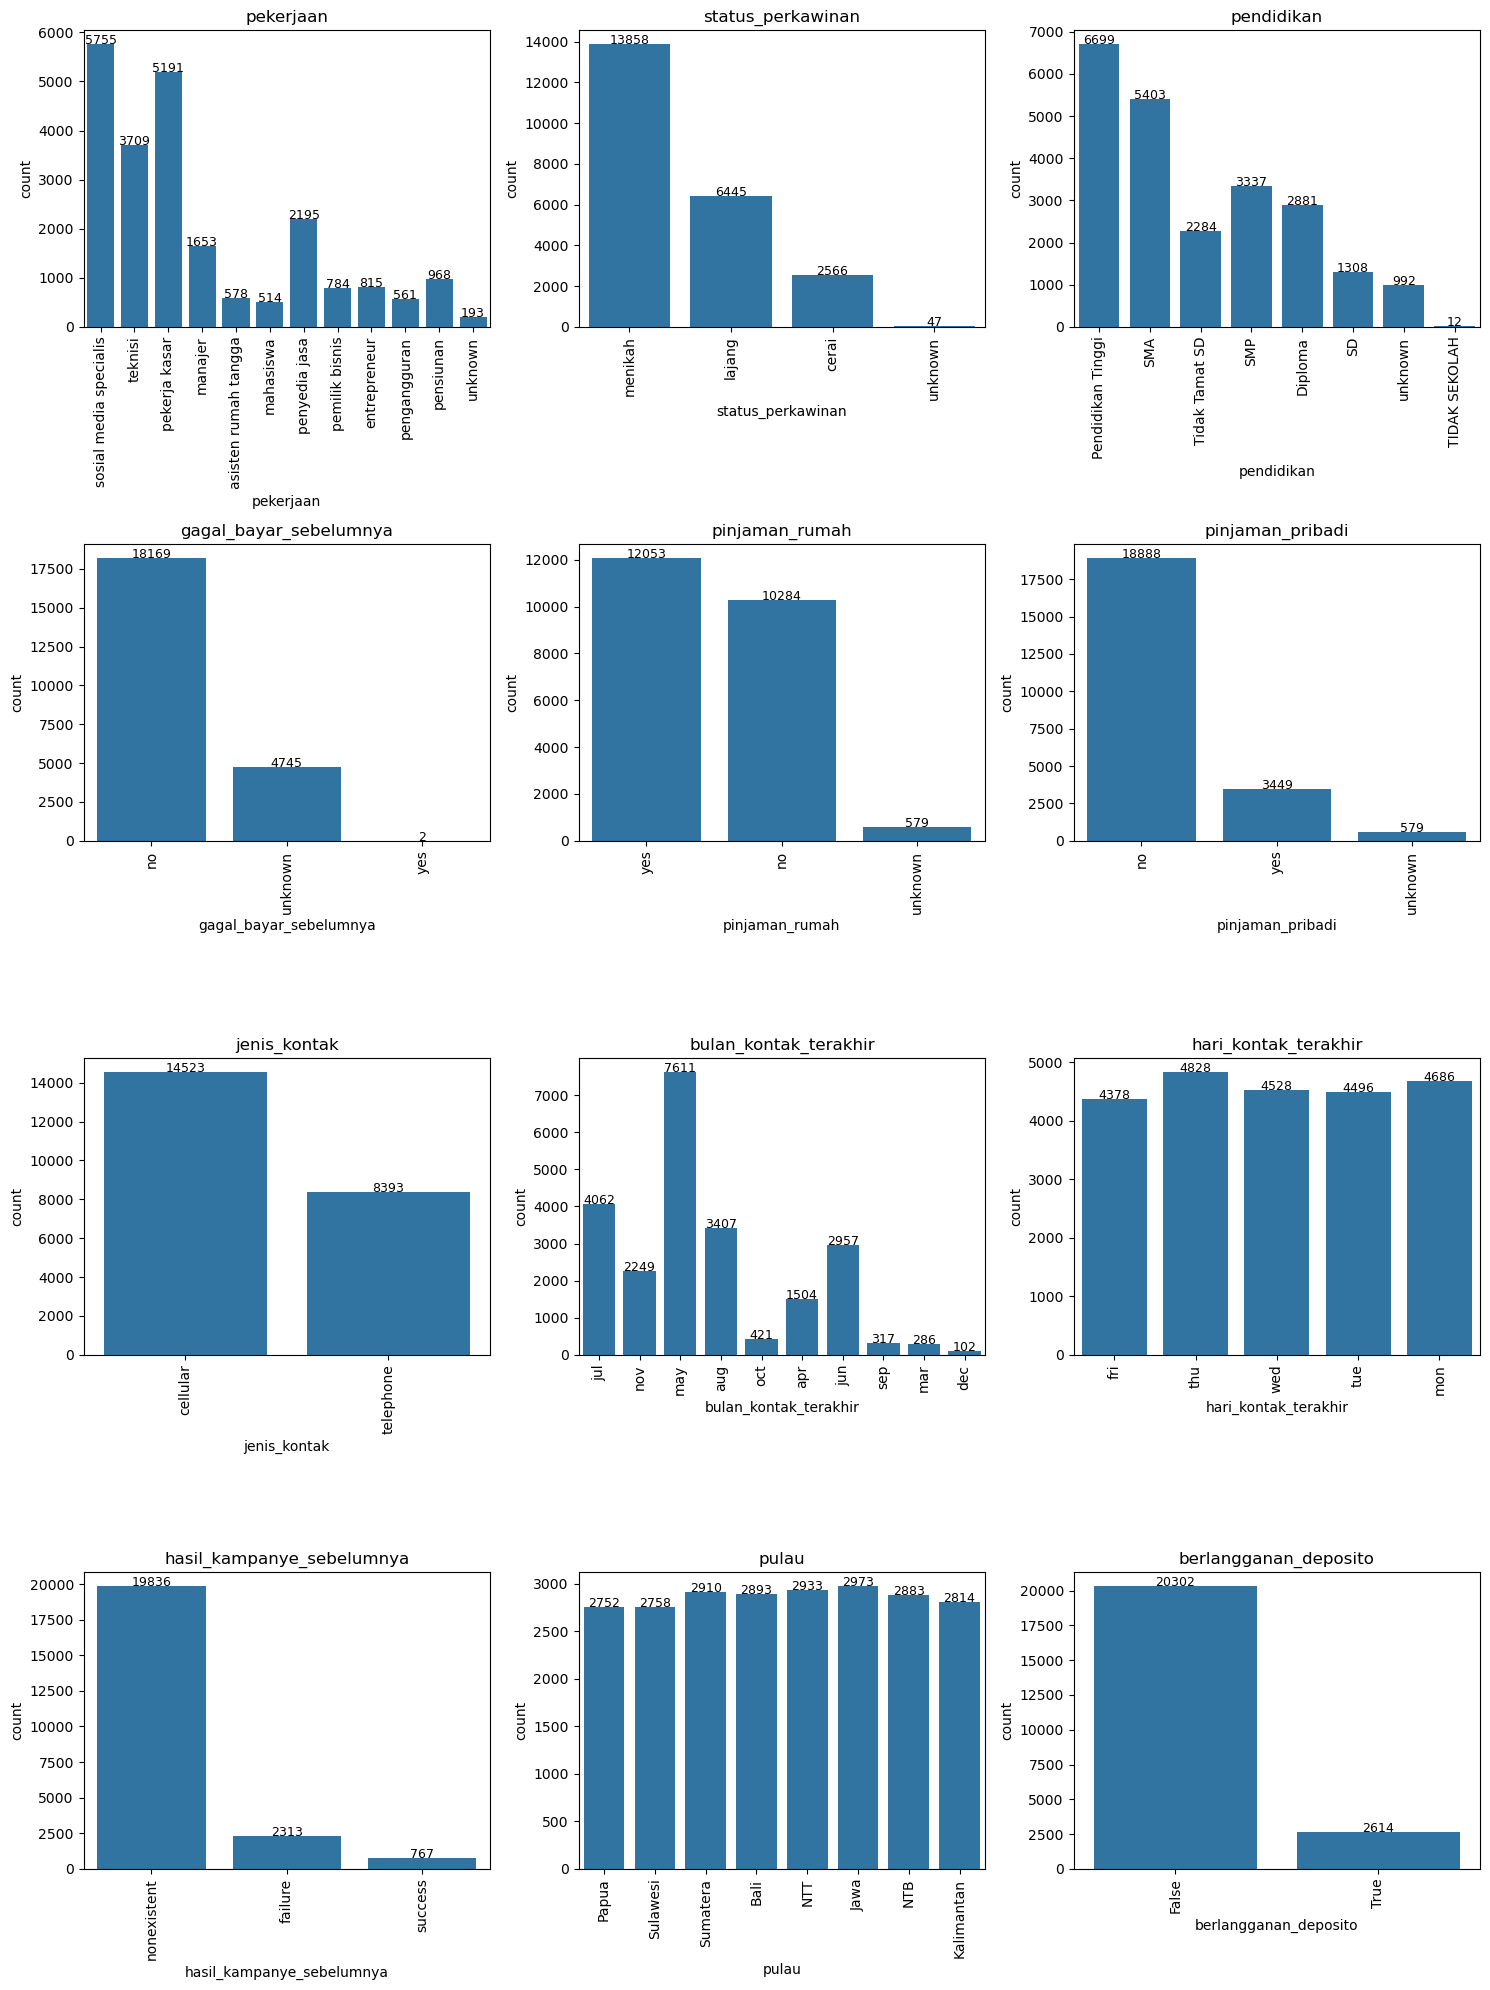

In [97]:
def plot_categorical_variables(df, columns):
    num_vars = len(columns)
    fig, axes = plt.subplots(
        nrows=(num_vars + 2) // 3, ncols=3, figsize=(15, 5 * ((num_vars + 2) // 3))
    )
    axes = axes.flatten()

    for i, col in enumerate(columns):
        # Create the countplot
        ax = sns.countplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].tick_params(axis="x", rotation=90)
        
        # Add count labels on top of each bar
        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width()/2.,
                height + 0.2,
                f'{int(height)}',
                ha="center", fontsize=9
            )

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Plot categorical variables in the training set
plot_categorical_variables(train, train_obj_columns)

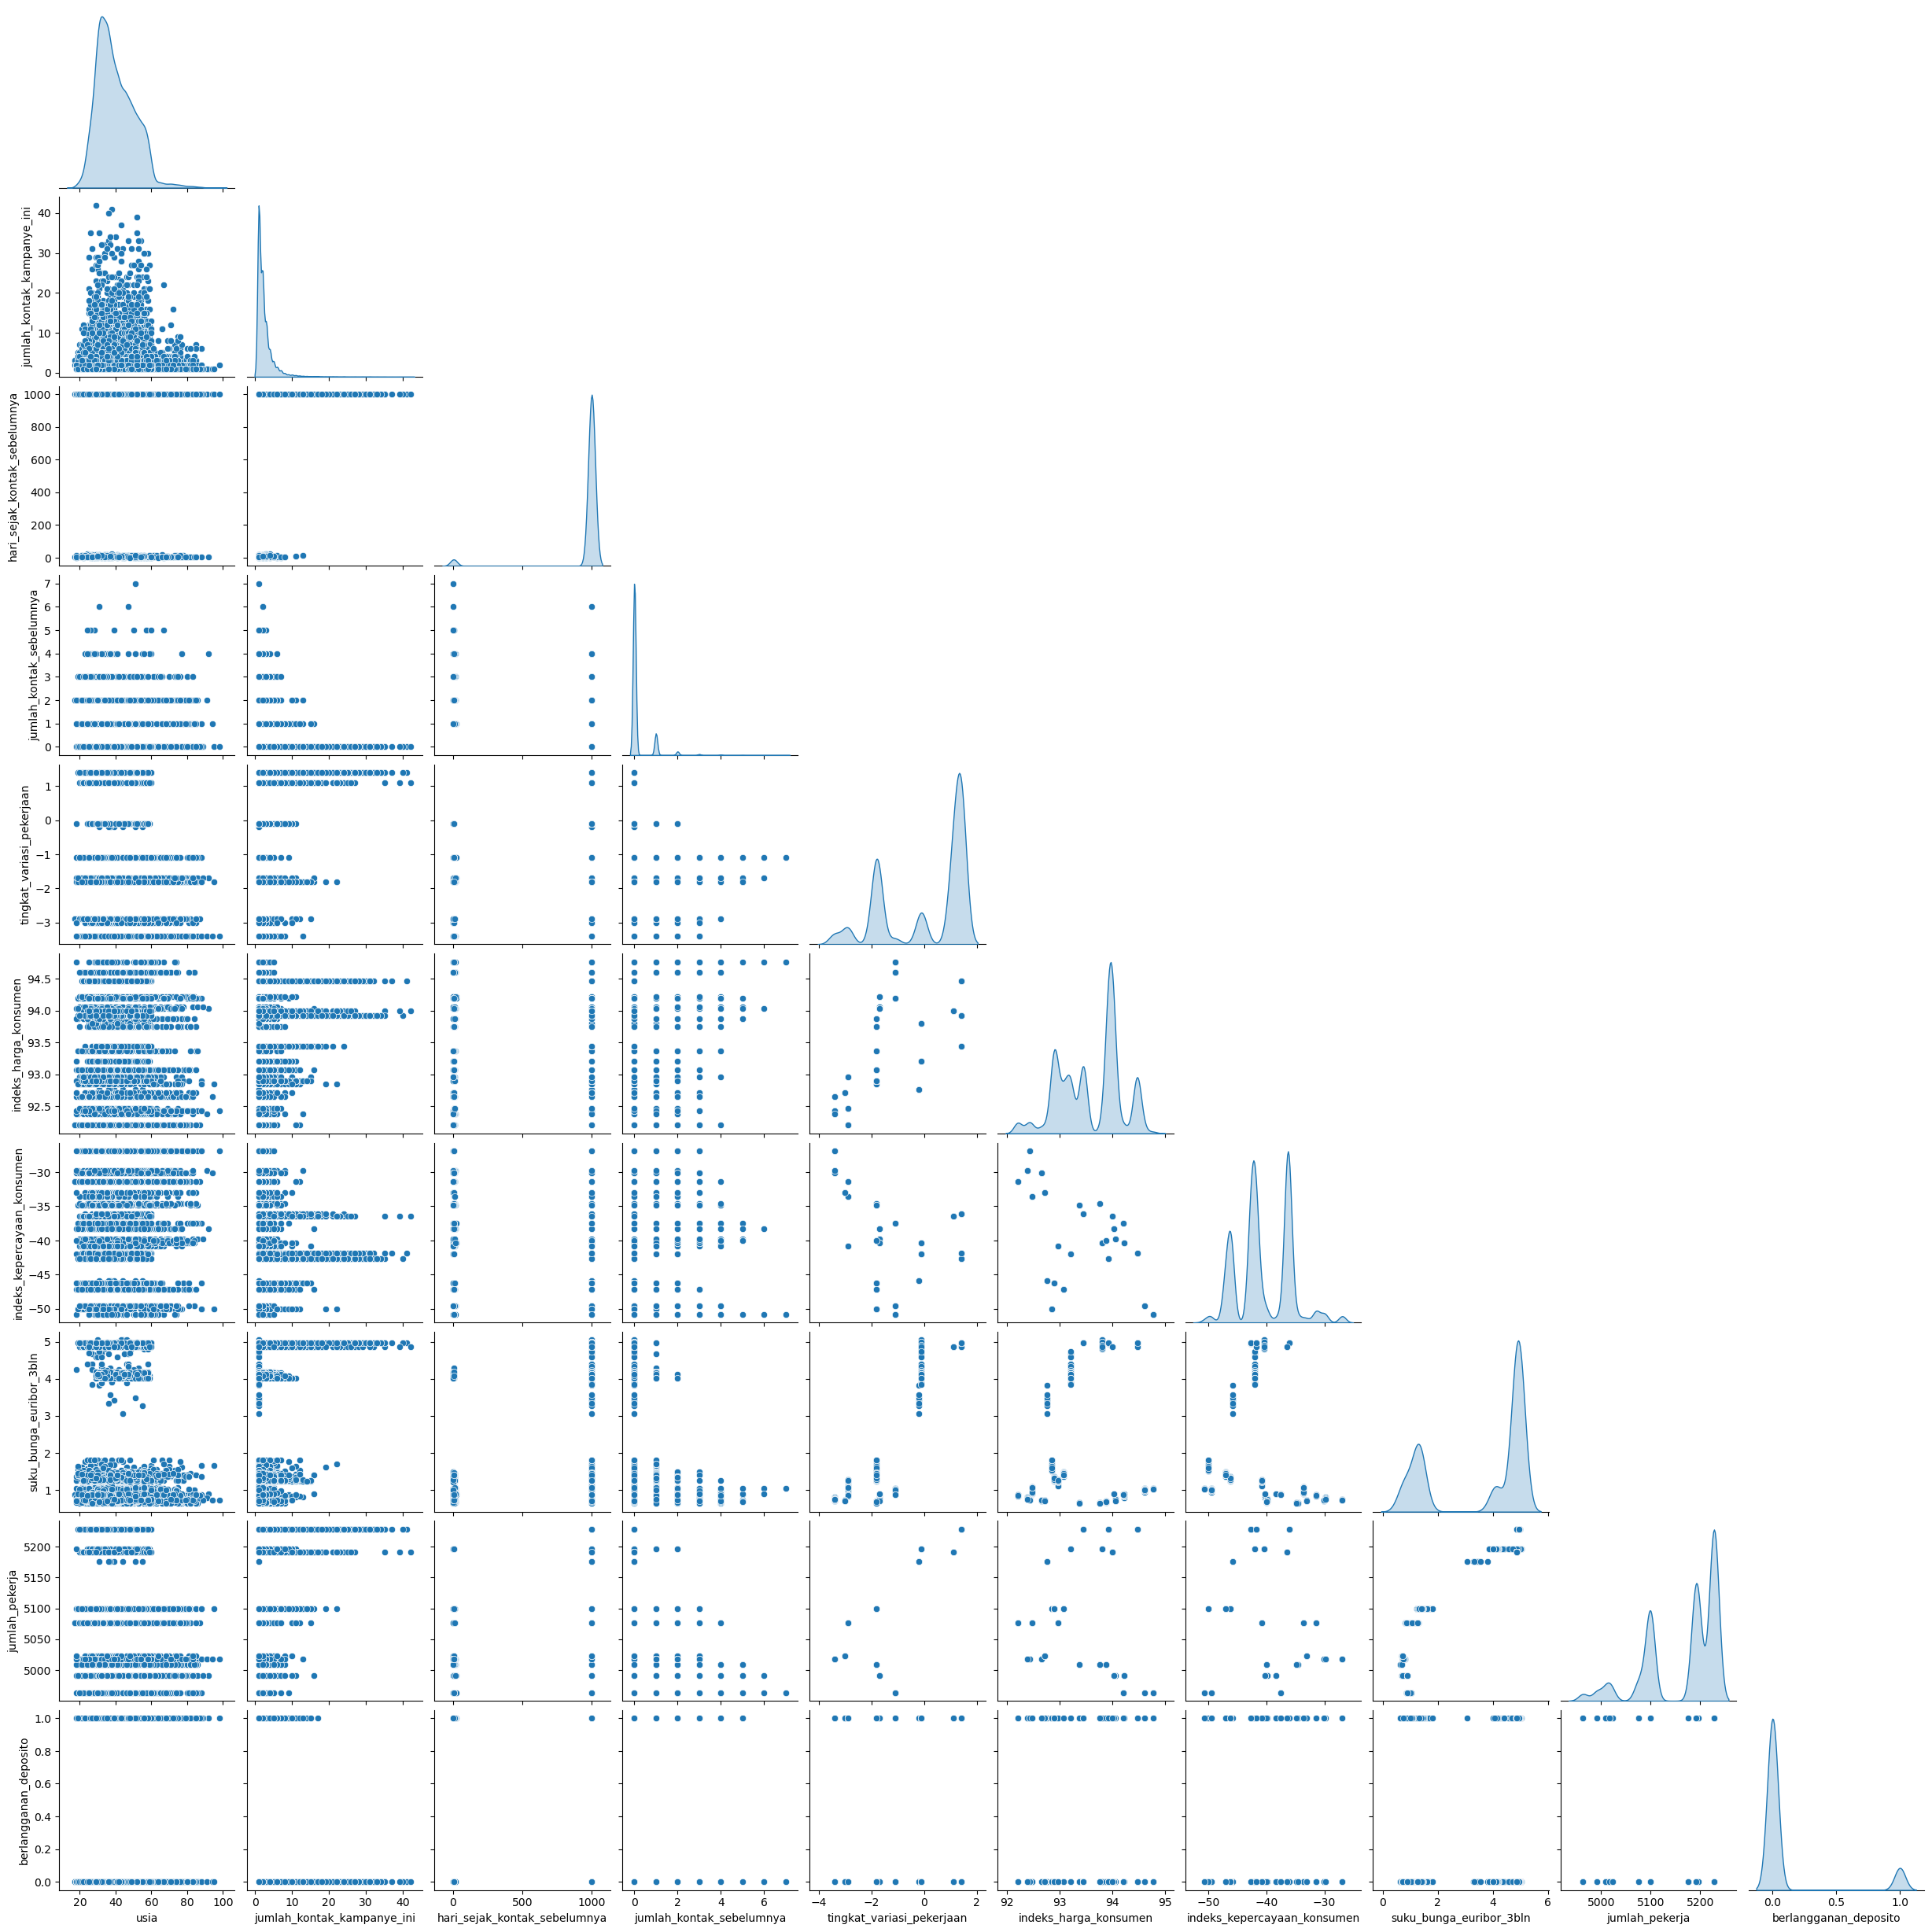

In [98]:
sns.pairplot(train_num, diag_kind='kde', corner=True)

<Axes: >

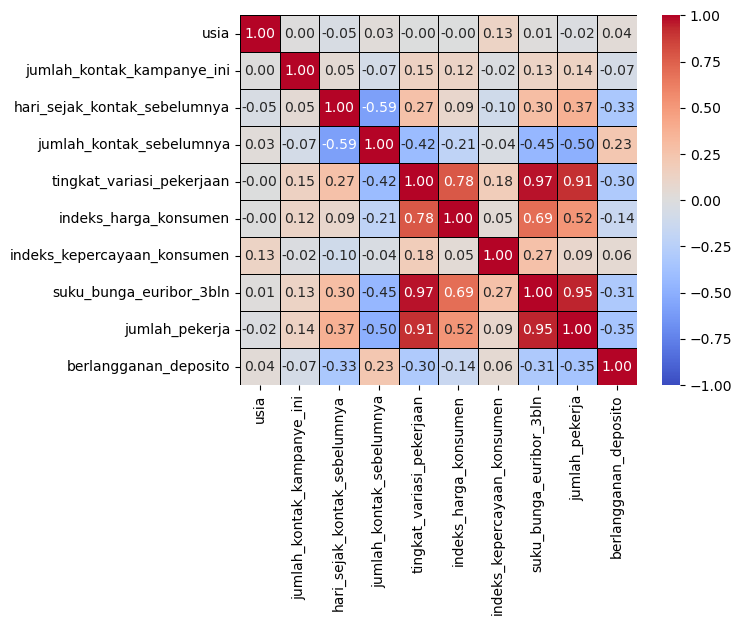

In [99]:
sns.heatmap(
    train_num.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor='black'
)

In [100]:
train, val = train_test_split(
    train, test_size=0.2, random_state=42, stratify=train['berlangganan_deposito']
)

X_train = train.drop(columns=['berlangganan_deposito'])
y_train = train['berlangganan_deposito']
X_val = val.drop(columns=['berlangganan_deposito'])
y_val = val['berlangganan_deposito']

In [ ]:
# Create a list of categorical features, excluding 'berlangganan_deposito'
cat_features = [col for col in train_obj_columns if col != 'berlangganan_deposito'] 
X_train_le = X_train.copy()
X_val_le = X_val.copy()

le = LabelEncoder()
for col in cat_features:
    X_train_le[col] = le.fit_transform(X_train[col])
    X_val_le[col] = le.transform(X_val[col])



models = {
    'CatBoost': CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        cat_features=cat_features,
        verbose=0,
        eval_metric='AUC',
        devices='0'  # Use GPU if available
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        num_leaves=31,
        boosting_type='gbdt',
        eval_metric='auc',
        objective='binary',
        random_state=42,
        device='gpu' if 'gpu' in LGBMClassifier().get_params() else 'cpu'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=6,
        eval_metric='auc',
        tree_method='gpu_hist' if 'gpu_hist' in XGBClassifier().get_params() else 'auto',
    )
}

results = {}
for model_name, model in models.items():
    if model_name == 'CatBoost':
        # CatBoost can handle categorical features natively
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)
        y_val_pred = model.predict_proba(X_val)[:, 1]
    else:
        # LightGBM and XGBoost need label-encoded features
        model.fit(X_train_le, y_train, eval_set=[(X_val_le, y_val)])
        y_val_pred = model.predict_proba(X_val_le)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    results[model_name] = auc
    
    print(f"{model_name} AUC: {auc:.4f}")
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    if model_name == 'CatBoost':
        y_val_pred = model.predict_proba(X_val)[:, 1]
    else:
        y_val_pred = model.predict_proba(X_val_le)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {results[model_name]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

CatBoost AUC: 0.7929
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 2091, number of negative: 16241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 18332, number of used features: 20
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114063 -> initscore=-2.049896
[LightGBM] [Info] Start training from score -2.049896
[LightGBM] [Warning] Unknown parameter: eval_metric
LightGBM AUC: 0.7506
[0]	validation_0-auc:0.78623
[1]	validation_0-auc:0.78747
[2]	validation_0-auc:0.79177
[3]	validation_0-auc:0.79559
[4]	validation_0-auc:0.79718
[5]	validation_0-auc:0.79582
[6]	validation_0-auc